# ANÁLISIS INICIAL DE FICHEROS Y PREPARACIÓN DEL CASO

En este notebook se realiza la **exploración inicial** y **limpieza** de los datasets que contienen la información de los alojamientos turísticos en Valencia.  
El objetivo es entender la **estructura de los datos**, identificar las **variables relevantes** para el análisis y preparar un dataset limpio que servirá como base para el **Datamart Analítico**.

## SETUP

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlalchemy as sa

%config IPCompleter.greedy = True

## ENTENDER LOS FICHEROS

Los dos ficheros que vamos a descargar de la web que antes hemos indicados son:
- listings.csv
- listings.csv.gz

Según la descripción de ambos corresponden al listing de todos los inmuebles registrados en AIRBNB, solo que en ambos el nivel de detalle de cada inmueble varía.


### Cargamos y entendemos listings

In [71]:
listings = pd.read_csv('../Datos/listings_sep.csv')

In [72]:
print(listings.shape)
listings.head(3)

(7844, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,83.0,3,197,2025-09-15,1.08,4,150,26,VT-41540-V
1,137143,PENTHOUSE ON FRONT LINE BEACH,670775,Maria De La Piedad,POBLATS DEL SUD,EL SALER,39.36335,-0.31932,Entire home/apt,390.0,10,1,2013-07-02,0.01,5,20,0,VT32745V
2,149715,1900 Style Valencian Beach Home for 10px,5947,Susana Barbara,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.46746,-0.32813,Entire home/apt,245.0,2,313,2025-09-15,1.81,1,287,41,ESFCTU000046025000580569000000000000000000VT-3...


In [73]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7844 entries, 0 to 7843
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7844 non-null   int64  
 1   name                            7844 non-null   object 
 2   host_id                         7844 non-null   int64  
 3   host_name                       7838 non-null   object 
 4   neighbourhood_group             7844 non-null   object 
 5   neighbourhood                   7844 non-null   object 
 6   latitude                        7844 non-null   float64
 7   longitude                       7844 non-null   float64
 8   room_type                       7844 non-null   object 
 9   price                           6979 non-null   float64
 10  minimum_nights                  7844 non-null   int64  
 11  number_of_reviews               7844 non-null   int64  
 12  last_review                     68

Este fichero recoge los datos hasta septiembre de 2025

Ya que podemos obtener los ficheros por trimestres, vamos a descargar los correspondientes a todo el año hasta septiembre 2025, y así, conseguir datos mayor consolidados en el mercado

In [74]:
sep25 = pd.read_csv('../Datos/listings_sep.csv')
jun25 = pd.read_csv('../Datos/listings_jun.csv')
mar25 = pd.read_csv('../Datos/listings_mar.csv')
dec24 = pd.read_csv('../Datos/listings_dic.csv')
listings = pd.concat([sep25,jun25,mar25,dec24])

In [75]:
listings.shape

(34399, 18)

Una vez tenemos los 4 trimestres en una misma tabla, vamos a quedarnos solo con aquellos registros que aparezcan 2 o más veces y que estén activos en el fichero más reciente que tenemos (sep25).

In [76]:
# Añadimos una columna 'conteo' para calcular las veces que se repite ese id
listings['conteo'] = listings.groupby('id')['id'].transform('count')

In [77]:
# Nos quedamos solo con los registros que tienen un conteo mayor o igual a 2, y que aparecen en la última tabla
listings = listings[(listings['conteo'] >= 2) & (listings['id'].isin(sep25['id']))].set_index('id').sort_index()

In [78]:
print(listings.shape)
listings.head(3)

(25904, 18)


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,conteo
id,,,,,,,,,,,,,,,,,,
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,83.0,3,197,2025-09-15,1.08,4,150,26,VT-41540-V,4
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,83.0,3,188,2025-06-04,1.05,4,146,27,VT-41540-V,4
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,154.0,3,177,2024-12-01,1.01,4,177,27,VT-41540-V,4


In [79]:
# Creamos la variable 'precio_medio'
listings['precio_medio'] = listings.groupby('id')['price'].transform('mean')
print(listings.shape)
listings.head(3)

(25904, 19)


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,conteo,precio_medio
id,,,,,,,,,,,,,,,,,,,
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,83.0,3,197,2025-09-15,1.08,4,150,26,VT-41540-V,4,117.5
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,83.0,3,188,2025-06-04,1.05,4,146,27,VT-41540-V,4,117.5
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,154.0,3,177,2024-12-01,1.01,4,177,27,VT-41540-V,4,117.5


Dejamos los registros únicos que tenemos y si alguno está duplicado, cogemos solo el primer registro que tenemos.

In [80]:
listings = listings.groupby('id').first().sort_values('id')
listings.shape

(7163, 19)

Finalmente, nos queda un dataset con 7.163 registros y 19 columnas. Ahora, de cada registro, tenemos el precio medio del alquiler durante los últimos 12 meses.

### Cargamos y entendemos listings_det

In [81]:
listings_det = pd.read_csv("../Datos/listings_det.csv")

In [82]:
print(listings_det.shape)
listings_det.head(3)

(7844, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,48154,https://www.airbnb.com/rooms/48154,20250923203019,2025-09-24,city scrape,Precioso apartamento con wifi,Second floor on a farm from the late 19th cent...,Very close neighborhood to the city's old town...,https://a0.muscache.com/pictures/1109085/9c0d4...,219476,...,4.80,4.52,4.52,VT-41540-V,f,4,4,0,0,1.08
1,137143,https://www.airbnb.com/rooms/137143,20250923203019,2025-09-24,city scrape,PENTHOUSE ON FRONT LINE BEACH,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,670775,...,5.00,4.00,4.00,VT32745V,f,5,5,0,0,0.01
2,149715,https://www.airbnb.com/rooms/149715,20250923203019,2025-09-24,city scrape,1900 Style Valencian Beach Home for 10px,Typical town house with 5 bedrooms and 4 bathr...,"Surrounded by historic houses, authentic res...",https://a0.muscache.com/pictures/808b4883-c57f...,5947,...,4.89,4.63,4.62,ESFCTU000046025000580569000000000000000000VT-3...,f,1,1,0,0,1.81


In [83]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7844 entries, 0 to 7843
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7844 non-null   int64  
 1   listing_url                                   7844 non-null   object 
 2   scrape_id                                     7844 non-null   int64  
 3   last_scraped                                  7844 non-null   object 
 4   source                                        7844 non-null   object 
 5   name                                          7844 non-null   object 
 6   description                                   7668 non-null   object 
 7   neighborhood_overview                         3277 non-null   object 
 8   picture_url                                   7844 non-null   object 
 9   host_id                                       7844 non-null   i

Primeras valoraciones de ambos ficheros:
- Ambos poseen el mismo número de registros pero el fichero de detalle tiene más columnas
- Ambos poseen la variable ID, por lo que podemos valorar unirlas mediante el campo ID

## CALIDAD DE DATOS

### Tabla listings

#### Visión general

In [84]:
print(listings.shape)
listings.head(3)

(7163, 19)


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,conteo,precio_medio
id,,,,,,,,,,,,,,,,,,,
48154,Precioso apartamento con wifi,219476,Antonio,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,83.0,3,197,2025-09-15,1.08,4,150,26,VT-41540-V,4,117.50
137143,PENTHOUSE ON FRONT LINE BEACH,670775,Cpi Gestión Encuentra Tu Mansión,POBLATS DEL SUD,EL SALER,39.36335,-0.31932,Entire home/apt,463.0,10,1,2013-07-02,0.01,5,30,0,VT32745V,4,408.25
149715,1900 Style Valencian Beach Home for 10px,5947,Susana Barbara,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.46746,-0.32813,Entire home/apt,204.0,2,279,2024-12-02,1.71,1,304,37,Nº TURISMO VT36469V CATEGORIA: standard,4,269.00


#### Variables y tipos

Eliminamos las variables que no necesitamos para nuestro análisis

In [85]:
a_eliminar = ['name',
             'host_name',
             'price',
             'number_of_reviews',
             'last_review',
             'reviews_per_month',
             'number_of_reviews_ltm',
             'conteo',
             'license',
             ]             
listings.drop(columns = a_eliminar, inplace = True)

In [86]:
print(listings.shape)
listings.head(3)

(7163, 10)


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,precio_medio
id,,,,,,,,,,
48154,219476,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,3,4,150,117.50
137143,670775,POBLATS DEL SUD,EL SALER,39.36335,-0.31932,Entire home/apt,10,5,30,408.25
149715,5947,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.46746,-0.32813,Entire home/apt,2,1,304,269.00


Pasamos las variables (neighbourhood_group, neighbourhood, room_type) a categóricas.

In [87]:
for variables in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    listings[variables] = listings[variables].astype('category')

Comprobamos

In [88]:
listings.dtypes

host_id                              int64
neighbourhood_group               category
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
minimum_nights                       int64
calculated_host_listings_count       int64
availability_365                     int64
precio_medio                       float64
dtype: object

Para facilitar la lectura vamos a cambiar el nombre de algunas variables.

In [89]:
listings = listings.rename(columns = {'precio_medio':'precio',
                                      'neighbourhood_group':'distrito',
                                      'neighbourhood':'barrio',
                                      'room_type':'tipo_alquiler',
                                      'minimum_nights':'minimo_noches',
                                      'calculated_host_listings_count':'total_inmuebles_host',
                                      'availability_365':'disponibilidad_365',
                                     })
listings.head(3)

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
48154,219476,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,3,4,150,117.50
137143,670775,POBLATS DEL SUD,EL SALER,39.36335,-0.31932,Entire home/apt,10,5,30,408.25
149715,5947,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.46746,-0.32813,Entire home/apt,2,1,304,269.00


#### Análisis de nulos

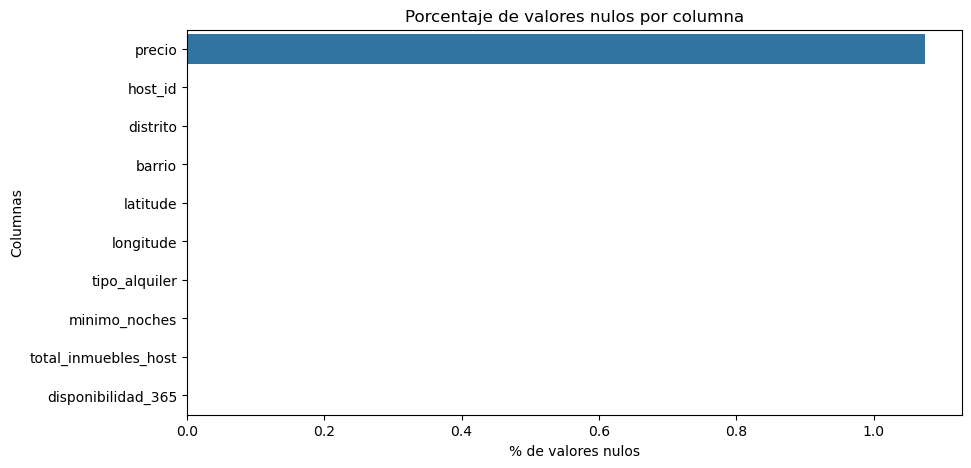

In [90]:
# Porcentaje de nulos por columna
nulls = listings.isnull().mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=nulls.values * 100, y=nulls.index)
plt.title("Porcentaje de valores nulos por columna")
plt.xlabel("% de valores nulos")
plt.ylabel("Columnas")
plt.show()

In [91]:
listings.isna().sum()

host_id                  0
distrito                 0
barrio                   0
latitude                 0
longitude                0
tipo_alquiler            0
minimo_noches            0
total_inmuebles_host     0
disponibilidad_365       0
precio                  77
dtype: int64

Vemos que solo tenemos nulos en la variable que hemos creado 'precio'. Vamos a comprobar a qué se debe.

In [92]:
listings[listings.precio.isna()].head()

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
2534892,6383590,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.464770,-0.332550,Entire home/apt,4,1,0,NaN
8770808,19089358,CAMINS AL GRAU,CAMI FONDO,39.466584,-0.356647,Entire home/apt,3,1,0,NaN
9321220,8182088,CIUTAT VELLA,LA XEREA,39.473120,-0.369600,Entire home/apt,29,1,0,NaN
16869072,48578830,EXTRAMURS,LA ROQUETA,39.466280,-0.378300,Private room,1,6,182,NaN
16869344,48578830,EXTRAMURS,LA ROQUETA,39.464280,-0.380550,Private room,1,5,285,NaN


Vamos a comprobar 

In [93]:
temp = listings[listings['precio'].isna()]
sep25_temp = sep25.loc[sep25.id.isin(temp.index)]
sep25_temp.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
95,2534892,Piso romantico Playa Cabanyal wifi,6383590,Sony,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.464770,-0.332550,Entire home/apt,NaN,31,264,2024-11-01,1.88,1,0,2,NaN
252,8770808,Zonnig appartement bij het park,19089358,Joosje,CAMINS AL GRAU,CAMI FONDO,39.466584,-0.356647,Entire home/apt,NaN,3,1,2024-12-15,0.11,1,0,1,NaN
262,9321220,Apt w/ Terrace in Valencia Old Town,8182088,Michael,CIUTAT VELLA,LA XEREA,39.473120,-0.369600,Entire home/apt,NaN,29,89,2025-06-15,0.74,1,0,9,VT-41962-V


In [94]:
sep25_temp.price.isna().sum()

77

Comprobamos que los nulos los arrastramos del dataset inicial y que son de la variable price. Dado que el número de nulos no es alto, optamos por dropear los nulos en listings

In [95]:
listings.dropna(inplace = True)

In [96]:
listings.precio.isna().sum()

0

#### Análisis de duplicados

In [97]:
listings.duplicated().sum()

3

In [98]:
listings[listings.duplicated()]

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
888917627369609766,465692074,CAMINS AL GRAU,ALBORS,39.465832,-0.351928,Entire home/apt,28,11,83,53.0
888928004216837447,465692074,CAMINS AL GRAU,ALBORS,39.465832,-0.351928,Entire home/apt,28,11,72,53.0
896809569186672639,465692074,CAMINS AL GRAU,ALBORS,39.465832,-0.351928,Entire home/apt,28,11,173,47.0


Observamos que el elemento duplicado, en realidad, son dos inmuebles distintos con 'id' diferentes.

#### Anáisis categóricas

Analizamos los valores y las frecuencias de las variables categóricas

In [99]:
listings.select_dtypes(include = ['O', 'category']).columns

Index(['distrito', 'barrio', 'tipo_alquiler'], dtype='object')

In [100]:
listings.distrito.value_counts()

distrito
POBLATS MARITIMS     1303
CIUTAT VELLA         1177
QUATRE CARRERES       745
CAMINS AL GRAU        673
L'EIXAMPLE            629
EXTRAMURS             577
LA SAIDIA             294
ALGIROS               293
JESUS                 258
L'OLIVERETA           205
PATRAIX               165
EL PLA DEL REAL       140
RASCANYA              132
BENICALAP             125
CAMPANAR              124
POBLATS DEL SUD       115
BENIMACLET             77
POBLATS DE L'OEST      46
POBLATS DEL NORD        8
Name: count, dtype: int64

In [101]:
listings.barrio.value_counts()

barrio
CABANYAL-CANYAMELAR    684
RUSSAFA                524
AIORA                  330
EL MERCAT              268
EL CARME               256
                      ... 
EL PALMAR                2
EL FORN D'ALCEDO         2
BORBOTO                  1
MAHUELLA-TAULADELLA      1
FAITANAR                 1
Name: count, Length: 85, dtype: int64

In [102]:
listings.tipo_alquiler.value_counts()

tipo_alquiler
Entire home/apt    5270
Private room       1791
Hotel room           15
Shared room          10
Name: count, dtype: int64

Para nuestro análisis sólo vamos a necesitar los registros que tengan la variable 'room_type' igual a Entire home/apt, por lo que vamos a quedarnos solo con estos

In [103]:
listings = listings.loc[listings['tipo_alquiler'] == 'Entire home/apt']

In [104]:
listings.tipo_alquiler.value_counts()

tipo_alquiler
Entire home/apt    5270
Hotel room            0
Private room          0
Shared room           0
Name: count, dtype: int64

#### Análisis numéricas

In [105]:
listings.iloc[:,6:10].describe().T

,count,mean,std,min,25%,50%,75%,max
minimo_noches,5270.0,5.658824,11.203060,1.0,1.0,2.0,4.000,300.0
total_inmuebles_host,5270.0,15.910436,26.145910,1.0,1.0,4.0,17.000,196.0
disponibilidad_365,5270.0,189.415560,111.112547,0.0,90.0,187.0,292.000,365.0
precio,5270.0,174.168074,453.437262,25.0,94.0,116.5,153.625,10000.0


Algunas conclusiones:
* De minimo_noches habría que revisar ese máximo de 300 días
* De total_inmuebles_host deberíamos revisar la media, ya que nos parece muy alta, y el valor máximo tambíen parece demasiado alto
* De la variable precio hay que revisar mínimos y máximos

Revisamos mínimos y máximos en el precio

##### Máximos

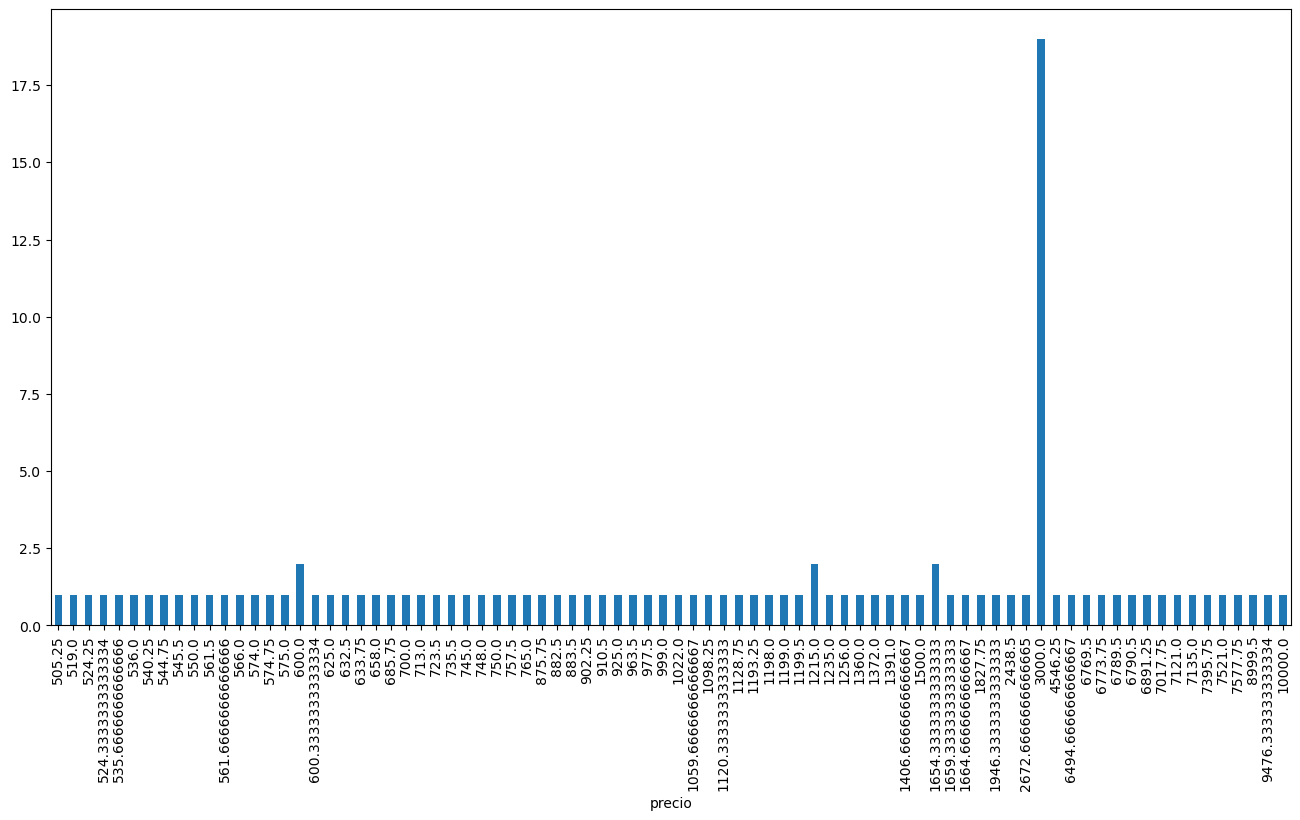

In [106]:
plt.figure(figsize=(16,8))
listings.precio.loc[listings.precio > 500].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusiones:
- Observamos que en el precio de 3000€ existen multiples registros, por lo que habrá que analizarlos y tomar alguna decisión 
- A partir de los 2672€ vemos que los precios incrementan exponecialmente por lo que podemos tomarlos como atípicos

Hacemos una búsqueda de los inmuebles con precio por noche de 3000€

In [107]:
listings[listings.precio == 3000]

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
1344783944678326358,402680959,POBLATS DEL SUD,PINEDO,39.386230,-0.332750,Entire home/apt,1,19,365,3000.0
1344785119327726616,402680959,POBLATS DEL SUD,EL SALER,39.386530,-0.331440,Entire home/apt,1,19,365,3000.0
1344786116692821060,402680959,POBLATS DEL SUD,PINEDO,39.386460,-0.332766,Entire home/apt,1,19,365,3000.0
1344787164459639516,402680959,POBLATS DEL SUD,PINEDO,39.388366,-0.332487,Entire home/apt,1,18,365,3000.0
1344789344235497298,402680959,POBLATS DEL SUD,EL SALER,39.388421,-0.330674,Entire home/apt,1,18,365,3000.0
1344790345179899930,402680959,POBLATS DEL SUD,EL SALER,39.386284,-0.331504,Entire home/apt,1,19,365,3000.0
1344792840754846763,402680959,POBLATS DEL SUD,EL SALER,39.388194,-0.331190,Entire home/apt,1,19,365,3000.0
1344793875856522001,402680959,POBLATS DEL SUD,PINEDO,39.386218,-0.332867,Entire home/apt,1,19,365,3000.0
1344794908111631129,402680959,POBLATS DEL SUD,EL SALER,39.386649,-0.331193,Entire home/apt,1,19,365,3000.0


Vemos que son 19 inmuebles y que pertenecen todos al mismo host_id. Al ver esto, hacemos una búsqueda en la web https://insideairbnb.com/valencia/ para localizar los inmuebles y comprobar los anuncios de este host en Airbnb.

Al hacerlo observamos que el host se trata de un camping a las afueras de Valencia, en concreto www.campingvalenciaelsaler.com.
Comprobamos que los precios que se indican en Airbnb no coinciden con los de su web. Tras ver esto y que en la cuenta de Airbnb no tienen ninguna reseña, determinamos que Airbnb solo lo usan como anuncio.

Ya que en la web tenemos los precios de cada apartamente, vamos a impurtar los precios correctos a estos inmubles. 

La media es de 70€

In [108]:
listings.loc[listings['precio'] == 3000, 'precio'] = 70

In [109]:
listings.loc[listings['host_id']== 402680959]

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
1344783944678326358,402680959,POBLATS DEL SUD,PINEDO,39.386230,-0.332750,Entire home/apt,1,19,365,70.0
1344785119327726616,402680959,POBLATS DEL SUD,EL SALER,39.386530,-0.331440,Entire home/apt,1,19,365,70.0
1344786116692821060,402680959,POBLATS DEL SUD,PINEDO,39.386460,-0.332766,Entire home/apt,1,19,365,70.0
1344787164459639516,402680959,POBLATS DEL SUD,PINEDO,39.388366,-0.332487,Entire home/apt,1,18,365,70.0
1344789344235497298,402680959,POBLATS DEL SUD,EL SALER,39.388421,-0.330674,Entire home/apt,1,18,365,70.0
1344790345179899930,402680959,POBLATS DEL SUD,EL SALER,39.386284,-0.331504,Entire home/apt,1,19,365,70.0
1344792840754846763,402680959,POBLATS DEL SUD,EL SALER,39.388194,-0.331190,Entire home/apt,1,19,365,70.0
1344793875856522001,402680959,POBLATS DEL SUD,PINEDO,39.386218,-0.332867,Entire home/apt,1,19,365,70.0
1344794908111631129,402680959,POBLATS DEL SUD,EL SALER,39.386649,-0.331193,Entire home/apt,1,19,365,70.0


Ahora vamos a eliminar los valores atípicos, que en nuestro caso hemos determinado que sean los que se encuentran por encima de los 3000€

In [110]:
listings = listings[listings['precio'] <= 3000]

In [111]:
listings.sort_values('precio', ascending = False).head()

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
1355665304714180513,66092872,QUATRE CARRERES,NA ROVELLA,39.450780,-0.370559,Entire home/apt,2,11,172,2672.666667
969359,5128253,POBLATS MARITIMS,NATZARET,39.448330,-0.334920,Entire home/apt,2,2,81,2438.500000
19169309,134051803,CIUTAT VELLA,EL MERCAT,39.472900,-0.378350,Entire home/apt,15,32,108,1946.333333
580147313303223192,5128253,POBLATS MARITIMS,NATZARET,39.448150,-0.334450,Entire home/apt,2,2,47,1827.750000
1207980361241852241,66092872,CAMINS AL GRAU,PENYA-ROJA,39.460343,-0.346179,Entire home/apt,1,11,131,1664.666667


##### Mínimos

In [112]:
listings.sort_values('precio', ascending = True).head()

,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
1423069955122889606,516655604,POBLATS DEL SUD,EL SALER,39.356390,-0.323550,Entire home/apt,3,5,130,25.0
1423050973913010074,516655604,POBLATS DEL SUD,EL SALER,39.356539,-0.325182,Entire home/apt,11,5,117,25.0
39417986,141206394,CIUTAT VELLA,EL CARME,39.477680,-0.376960,Entire home/apt,60,1,83,26.0
1422996085993533843,516655604,POBLATS DEL SUD,EL SALER,39.355388,-0.324104,Entire home/apt,3,5,214,26.5
1423088917794712769,516655604,POBLATS DEL SUD,EL SALER,39.356569,-0.323789,Entire home/apt,5,5,170,29.0


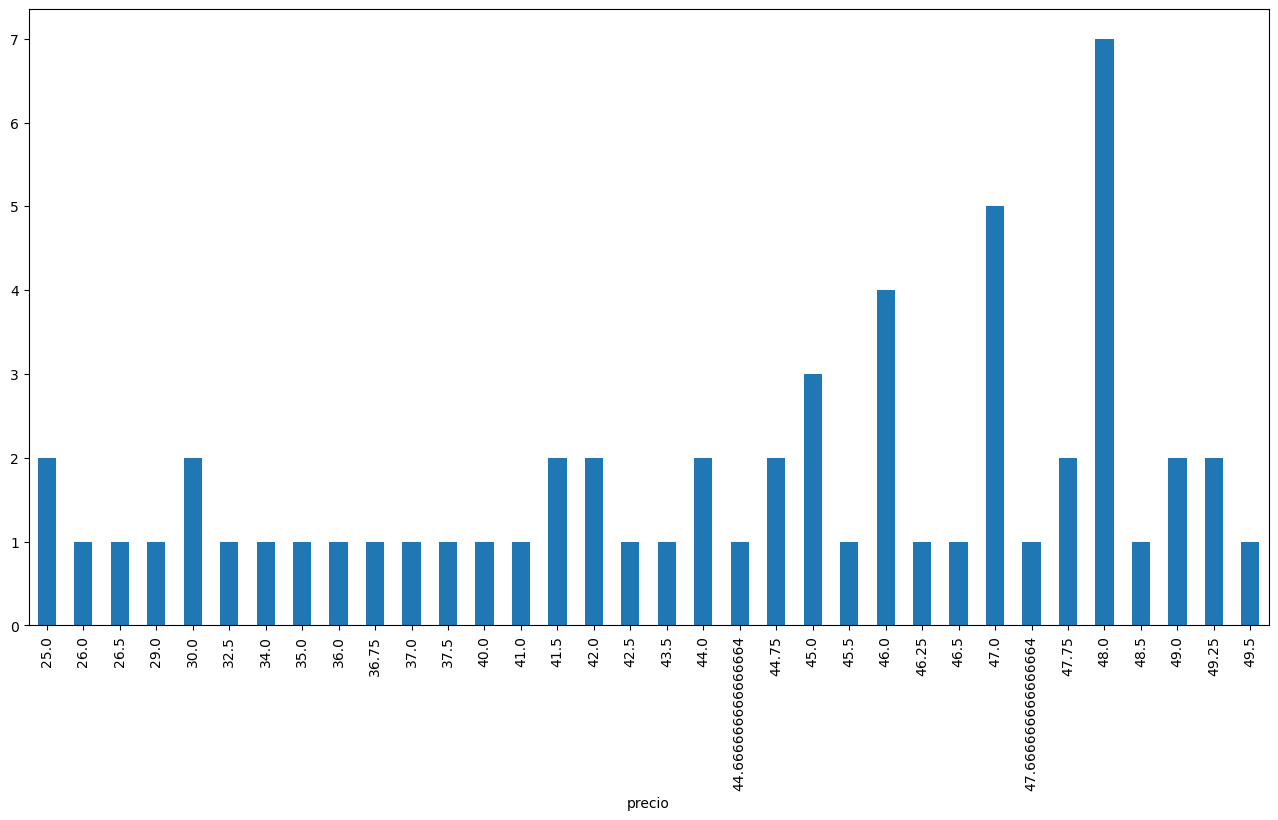

In [113]:
plt.figure(figsize=(16,8))
listings.precio.loc[listings.precio < 50].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Todo bien

##### Minimo_noches

Vamos a comprobar los registros con el minimo de noches más altos

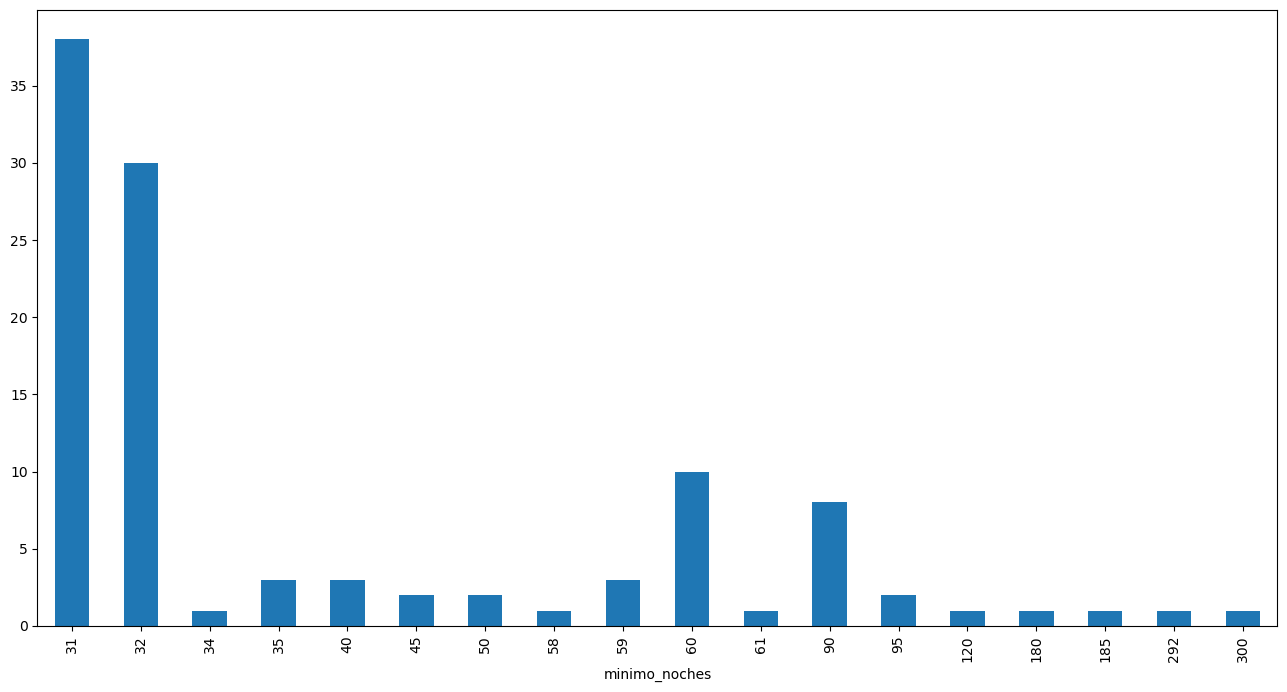

In [114]:
plt.figure(figsize=(16,8))
listings.minimo_noches.loc[listings.minimo_noches > 30].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Vemos que los atípicos en este caso los valores atípicos no son muy numerosos. Aun así, vamos a descartar los registros con un minimo_noches por encima de 100, ya que son inmuebles que buscan alquileres de media estancia, y no de corta estancia como es el motivo de nuestro análisis

In [115]:
listings = listings[listings['minimo_noches'] <= 100]

In [116]:
print(listings.shape)
listings.head(3)

(5249, 10)


,host_id,distrito,barrio,latitude,longitude,tipo_alquiler,minimo_noches,total_inmuebles_host,disponibilidad_365,precio
id,,,,,,,,,,
48154,219476,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,3,4,150,117.50
137143,670775,POBLATS DEL SUD,EL SALER,39.36335,-0.31932,Entire home/apt,10,5,30,408.25
149715,5947,POBLATS MARITIMS,CABANYAL-CANYAMELAR,39.46746,-0.32813,Entire home/apt,2,1,304,269.00


Al final nos quedamos con un dataset listings de 5249 registros y 10 variables

### Tabla listings_det

#### Visión general

In [117]:
print(listings_det.shape)
listings_det.head(3)

(7844, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,48154,https://www.airbnb.com/rooms/48154,20250923203019,2025-09-24,city scrape,Precioso apartamento con wifi,Second floor on a farm from the late 19th cent...,Very close neighborhood to the city's old town...,https://a0.muscache.com/pictures/1109085/9c0d4...,219476,...,4.80,4.52,4.52,VT-41540-V,f,4,4,0,0,1.08
1,137143,https://www.airbnb.com/rooms/137143,20250923203019,2025-09-24,city scrape,PENTHOUSE ON FRONT LINE BEACH,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,670775,...,5.00,4.00,4.00,VT32745V,f,5,5,0,0,0.01
2,149715,https://www.airbnb.com/rooms/149715,20250923203019,2025-09-24,city scrape,1900 Style Valencian Beach Home for 10px,Typical town house with 5 bedrooms and 4 bathr...,"Surrounded by historic houses, authentic res...",https://a0.muscache.com/pictures/808b4883-c57f...,5947,...,4.89,4.63,4.62,ESFCTU000046025000580569000000000000000000VT-3...,f,1,1,0,0,1.81


#### Variables y tipos

Nos quedamos solo con las variables que vamos a utilizar para nuestro análisis

In [118]:
a_incluir = ['id',
            'accommodates',
            'bathrooms',
            'bedrooms',
            'beds',            
            ]
listings_det = listings_det.loc[:,a_incluir]
listings_det.head(3)

,id,accommodates,bathrooms,bedrooms,beds
0,48154,4,1.0,2.0,2.0
1,137143,7,1.5,1.0,14.0
2,149715,10,4.0,5.0,7.0


In [119]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7844 entries, 0 to 7843
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            7844 non-null   int64  
 1   accommodates  7844 non-null   int64  
 2   bathrooms     6976 non-null   float64
 3   bedrooms      7532 non-null   float64
 4   beds          6976 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 306.5 KB


#### Análisis de nulos

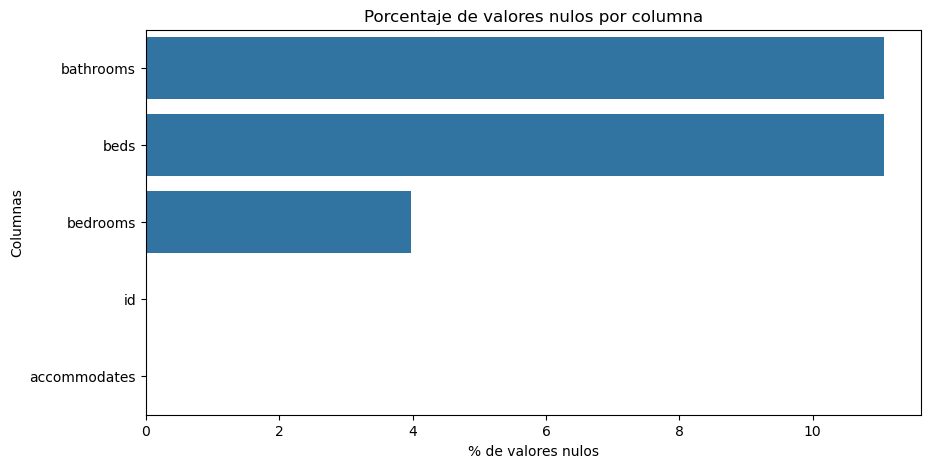

In [120]:
# Porcentaje de nulos por columna
nulls = listings_det.isnull().mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=nulls.values * 100, y=nulls.index)
plt.title("Porcentaje de valores nulos por columna")
plt.xlabel("% de valores nulos")
plt.ylabel("Columnas")
plt.show()

In [121]:
listings_det.isna().sum()

id                0
accommodates      0
bathrooms       868
bedrooms        312
beds            868
dtype: int64

Tras observar el número de nulos que tiene la variable bathrooms determinamos que finalmente no la vamos a incluir en nuestro análisis

In [122]:
# Dropeamos 'bathrooms'
listings_det.drop(columns = 'bathrooms', inplace = True)
listings_det.head(3)

,id,accommodates,bedrooms,beds
0,48154,4,2.0,2.0
1,137143,7,1.0,14.0
2,149715,10,5.0,7.0


Echamos un vistazo a los nulos de bedrooms

In [123]:
listings_det.loc[listings_det.bedrooms.isna()]

,id,accommodates,bedrooms,beds
12,276455,1,NaN,NaN
81,1842193,2,NaN,NaN
100,2706156,3,NaN,NaN
186,6272168,1,NaN,NaN
206,6923443,2,NaN,NaN
...,...,...,...,...
7562,1467996550905452026,3,NaN,2.0
7579,1470282447679796205,2,NaN,NaN
7620,1475362075811810522,2,NaN,1.0
7621,1475363598766841133,2,NaN,1.0


Al analizar los valores nulos, vemos que en prácticamente todos los registros los valores de beds tambíen son nulos. 

La variable bedrooms es una de las más importante para nuestro análisis, por lo que vamos a tratar de imputar esos nulos a partir de las demás variables.

Primero vamos a ver si existe relación entre las variables bedrooms, beds y accommodates cruzándolas entre ellas.

In [124]:
# Cruzamos bedrooms con accommodates:
pd.crosstab(listings_det.bedrooms, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
bedrooms,,,,,,,,,,,,,,,,
0.0,20,147,82,176,4,5,0,2,0,3,0,2,0,0,0,1
1.0,614,1842,469,1164,41,56,1,6,0,0,0,2,0,0,0,4
2.0,19,55,181,950,174,279,12,15,2,1,2,1,0,1,0,1
3.0,8,16,9,157,225,353,46,98,7,4,1,0,0,0,0,0
4.0,11,5,0,7,21,51,27,58,6,10,3,4,0,1,0,2
5.0,2,0,0,0,5,3,1,11,3,12,2,2,1,0,0,1
6.0,2,0,0,0,0,0,0,0,0,1,1,2,1,1,1,2
7.0,1,0,0,0,0,0,5,1,0,0,0,1,0,1,0,0
8.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
# Cruzamos bedrooms con beds:
pd.crosstab(listings_det.bedrooms, listings_det.beds)

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,20.0,22.0,23.0
bedrooms,,,,,,,,,,,,,,,,,,,,,
0.0,16,163,236,15,9,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,83,2355,1262,190,48,9,2,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2.0,26,44,606,584,190,28,10,6,0,2,...,0,0,0,0,1,0,0,0,0,0
3.0,7,10,15,332,248,136,44,11,3,2,...,0,0,0,0,0,0,0,0,0,0
4.0,2,6,1,5,66,36,21,17,7,3,...,0,1,1,0,0,0,1,0,0,0
5.0,0,2,1,0,0,18,5,2,3,4,...,1,0,0,0,0,0,0,1,0,0
6.0,0,2,0,0,0,0,1,1,1,0,...,0,1,0,0,1,0,0,0,0,0
7.0,0,0,0,0,0,1,0,6,0,0,...,0,1,0,0,0,0,0,0,0,0
10.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [126]:
# Cruzamos beds con accommodates:
pd.crosstab(listings_det.beds, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16
beds,,,,,,,,,,,,,,,
0.0,13,42,15,39,11,8,0,1,0,2,0,2,0,0,1
1.0,599,1599,118,270,6,10,0,1,0,0,0,0,0,0,0
2.0,29,270,492,1285,37,25,1,3,0,1,0,0,0,0,1
3.0,7,32,59,539,214,262,5,6,1,0,0,0,0,0,1
4.0,2,9,10,111,113,235,29,48,2,1,1,0,0,0,0
5.0,3,2,0,13,26,92,25,55,3,9,1,0,0,0,1
6.0,0,0,0,3,2,21,11,34,3,5,0,4,1,0,0
7.0,1,0,0,0,1,3,10,19,3,2,3,0,0,0,1
8.0,0,0,0,0,0,2,0,6,2,2,1,1,1,0,0


Tras analizar las tres crosstabs determinamos que:
* La mejor relación es entre las variables bedrooms y beds
* Para poder imputar bedrooms a través de beds, debemos primero imputar los nulos de beds
* Para imputar los nulos de beds lo haremos a través de accommodates

##### Imputar Beds

Vemos la frecuencia de registros de la variable beds contando con los nulos y decidimos imputar de la siguiente forma:

La imputación de beds lo haremos de la siguiente manera:

* Una o dos personas se suelen corresponder con una cama
* Tres o cuatro personas se suelen corresponder con dos camas
* Cinco o seis personas se suelen corresponder con tres camas
* A más de 6 personas le vamos a poner cuatro camas

In [127]:
listings_det.beds.value_counts(dropna = False)

beds
1.0     2603
2.0     2144
3.0     1126
NaN      868
4.0      561
5.0      230
0.0      134
6.0       84
7.0       43
8.0       15
9.0       11
10.0       6
11.0       3
13.0       3
20.0       3
14.0       2
16.0       2
23.0       1
22.0       1
12.0       1
17.0       1
15.0       1
18.0       1
Name: count, dtype: int64

Creamos una función para imputar los nulos de beds en base a accommodates:

In [128]:
def imputar_nulos(registro):
    #Lista de condiciones
    condicion = [(registro.accommodates <= 2),
                 (registro.accommodates > 2) & (registro.accommodates <= 4),
                 (registro.accommodates > 4) & (registro.accommodates <= 6),
                 (registro.accommodates > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]

    #Salida
    return(np.select(condicion, resultados, default = -9999))

listings_det.loc[listings_det.beds.isna(),'beds'] = listings_det.loc[listings_det.beds.isna()].apply(imputar_nulos, axis = 1).astype('float64')

Comprobamos de nuevo la relación de beds:

In [129]:
listings_det.beds.value_counts(dropna = False)

beds
1.0     3006
2.0     2426
3.0     1275
4.0      595
5.0      230
0.0      134
6.0       84
7.0       43
8.0       15
9.0       11
10.0       6
20.0       3
13.0       3
11.0       3
14.0       2
16.0       2
22.0       1
12.0       1
17.0       1
15.0       1
23.0       1
18.0       1
Name: count, dtype: int64

##### Imputar Bedrooms

In [130]:
pd.crosstab(listings_det.bedrooms, listings_det.beds)

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,20.0,22.0,23.0
bedrooms,,,,,,,,,,,,,,,,,,,,,
0.0,16,163,236,15,9,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,83,2484,1374,194,49,9,2,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2.0,26,58,735,633,193,28,10,6,0,2,...,0,0,0,0,1,0,0,0,0,0
3.0,7,16,35,411,257,136,44,11,3,2,...,0,0,0,0,0,0,0,0,0,0
4.0,2,12,2,20,80,36,21,17,7,3,...,0,1,1,0,0,0,1,0,0,0
5.0,0,2,1,2,3,18,5,2,3,4,...,1,0,0,0,0,0,0,1,0,0
6.0,0,2,0,0,3,0,1,1,1,0,...,0,1,0,0,1,0,0,0,0,0
7.0,0,0,0,0,1,1,0,6,0,0,...,0,1,0,0,0,0,0,0,0,0
8.0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Hacemos la imputación de bedrooms a partir de beds de la siguiente forma:

* Cero, una o dos camas se suelen corresponder con una habitación
* Tres o cuatro camas suelen corresponder a dos habitaciones
* Cinco o seis camas se suelen corresponder con tres habitaciones
* A más de seis camas le podemos imputar cuatro habitaciones

Comprobamos primero el conteo de bedrooms:

In [131]:
listings_det.bedrooms.value_counts(dropna=False)

bedrooms
1.0     4199
2.0     1693
3.0      924
0.0      442
NaN      312
4.0      206
5.0       43
6.0       11
7.0        9
8.0        2
12.0       1
17.0       1
10.0       1
Name: count, dtype: int64

Usamos la función que hemos creado antes pero ahora para imputar los nulos de bedrooms en base a beds:

In [132]:
def imputar_nulos(valor):
    #lista de condiciones
    condicion = [(valor.beds <=2),
                (valor.beds > 2) & (valor.beds <=4),
                (valor.beds > 4) & (valor.beds <= 6),
                (valor.beds > 6)]

    # Lista de resultados
    resultados = [1,2,3,4]
    
    # Salida
    return(np.select(condicion, resultados, default = -9999))

listings_det.loc[listings_det.bedrooms.isna(),'bedrooms'] = listings_det.loc[listings_det.bedrooms.isna()].apply(imputar_nulos, axis = 1).astype('float64')

In [133]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
1.0     4509
2.0     1693
3.0      924
0.0      442
4.0      208
5.0       43
6.0       11
7.0        9
8.0        2
12.0       1
17.0       1
10.0       1
Name: count, dtype: int64

In [134]:
listings_det.isna().sum()

id              0
accommodates    0
bedrooms        0
beds            0
dtype: int64

#### Análisis de duplicados

In [135]:
listings_det.duplicated().sum()

0

#### Análisis categóricas

Hemos descartado todas las variables categóricas

#### Análisis numéricas

In [136]:
listings_det.drop('id',axis = 1).describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
accommodates,7844.0,3.505609,1.880761,1.0,2.0,4.0,4.0,16.0
bedrooms,7844.0,1.516828,0.974675,0.0,1.0,1.0,2.0,17.0
beds,7844.0,2.115757,1.467611,0.0,1.0,2.0,3.0,23.0


No vemos nada raro en ninguna de las variables numéricas

## Guardar Datasets

In [137]:
listings.to_pickle('../Datos/listings.pickle')

In [138]:
listings_det.to_pickle('../Datos/listings_det.pickle')